In [25]:
import numpy as np # быстрые математические вычисления, работа с массивами
import matplotlib.pyplot as plt # рисует графики, поля, траектории
from scipy.integrate import solve_ivp

In [26]:
def f1(sigma, gamma):  # это параметр омега в линейном осцилляторе
    def rhs(t, X):      # правая часть ДУ (Differential Equation Right-Hand Side)
        x, y = X        # X — это вектор состояния системы (x - координата, y - скорость)
        return [y, -2*sigma*y - gamma*x]  # возвращает dx/dt и dy/dt
    return rhs


In [27]:
test = f1(1.0,1.0)

test(10.0, [4.0,5.0])


[5.0, -14.0]

In [28]:
# Функция для вычисления векторного поля
def vector_field_calculation(rhs, limits, N=16): #
    xs,ys = limits # в лимитсе как то храним, границы поля?

    xs = np.linspace(xs[0],xs[1],N) # генерируем сетку равномерно распределенных чисел в заданном интервале
    ys = np.linspace(ys[0],ys[1],N)
    U, V = np.zeros((N,N)), np.zeros((N,N)) # переписываем в эти два массива нули
        #U[i][j] будет хранить компоненту скорости по оси x
        #V[i][j] - компоненту скорости по оси у для точки с координатами (x[j], y[j]?)

    for i, y in enumerate (ys): # i получает индекс (0, 1, 2, ...). y[i] получает значение элемента.
            for j,x in enumerate (xs):
                u,v = rhs(0.0, [x,y])

                U[i][j] = u
                V[i][j] = v
            # проходим по всемм точкам сетки с координатами х у
            # вызываем функцию rhs(0.0, [x,y]), которая возвращает
            #вектор скорости в этой точке
            #значение компонент вектора u v сохраняются в массивы U V
    return xs,ys,U,V



In [29]:
def drawing_vector_field(rhs, limits):
    #plt.close() - можно раскоментить, но тогда придется перекинуть отрисовку сепаратрис пониже (...)
    xlims, ylims = limits
    plt.xlim(xlims[0],xlims[1]) # задаем границы поля по x
    plt.ylim(ylims[0],ylims[1]) # задаем границы поля по y
    xs,ys,U,V = vector_field_calculation(rhs, limits)
    plt.quiver(xs,ys, U, V, alpha=1) # plt.quiver рисует именно вектор из xs ys, в направлении



In [30]:
def create_jacobian(sigma, gamma):
    # x'' + 2(sigma)x' + (gamma)y = 0 из этого уравнения сделали системку:
    # x' = y
    # y' = -2(gamma)y - (sigma)x
    return np.array([[0, 1],[-gamma, -2*sigma]])

In [31]:
def solve_eigenvalues_and_jacobian(sigma, gamma):
    J = create_jacobian(sigma, gamma)
    # Вычисление собственных чисел и векторов
    eigenvalues, eigenvectors = np.linalg.eig(J)
    return eigenvalues, eigenvectors
    # eigenvalues - массив содержащий собственные числа (lambda1, lambda2)
    # eigenvectors - массив содержащий соответствующие собственные векторы

In [32]:
def stability_type(eigenvalues): # получает значения собственных чисел
    lambda_1 = eigenvalues[0] # первое собственное число
    lambda_2 = eigenvalues[1] # второе собственное число
    r1, r2 = lambda_1.real, lambda_2.real
    i1, i2 = lambda_1.imag, lambda_2.imag

    # -------------------------
    # Оба отрицательные
    if r1 < 0 and r2 < 0:
        if abs(i1) > 1e-12 or abs(i2) > 1e-12:
            return "устойчивый фокус", 0
        else:
            if abs(lambda_1 - lambda_2) < 1e-12:
                return "устойчивый вырожденный узел", 1
            else:
                return "устойчивый узел", 2

    # Оба положительные
    if r1 > 0 and r2 > 0:
        if abs(i1) > 1e-12 or abs(i2) > 1e-12:
            return "неустойчивый фокус", 3
        else:
            if abs(lambda_1 - lambda_2) < 1e-12:
                return "неустойчивый вырожденный узел", 4
            else:
                return "неустойчивый узел", 5

    # Разного знака
    if (r1 > 0 and r2 < 0) or (r1 < 0 and r2 > 0):
        return "седло", 6

    # Один ноль, другой отрицательный → нейтральная устойчивость
    if (abs(r1) < 1e-12 and r2 < 0) or (abs(r2) < 1e-12 and r1 < 0):
        return "нейтральный узел", 7

    # Один ноль, другой положительный → неустойчивость
    if (abs(r1) < 1e-12 and r2 > 0) or (abs(r2) < 1e-12 and r1 > 0):
        return "нейтральное седло", 8

    # Чисто мнимые → центр
    if abs(r1) < 1e-12 and abs(r2) < 1e-12:
        if abs(i1 + i2) < 1e-12 and abs(i1) > 1e-12:
            return "центр", 9
        else:
            return "нулевые собственные числа", 10



In [33]:
def _draw_quiver_pair(x0, y0, v, scale, color, invert=False, zorder=5):
    """
    Рисует стрелки (векторы) вдоль направления v, исходящие из точки равновесия (x0, y0) или входящие в неё.
    - invert=True (стабильное направление): две стрелки направлены к центру (от концов к x0,y0).
    - invert=False (неустойчивое направление): две стрелки исходят из центра (от x0,y0).
    """

    v = np.array(v, dtype=float) # Преобразуем входной вектор v в массив NumPy с плавающей точкой.
    v /= np.linalg.norm(v) # Нормализуем вектор v (делим на его длину), чтобы получить единичный вектор направления.

    if invert: # Проверяем флаг 'invert' для рисования устойчивой сепаратрисы (стрелки направлены К центру).
        # Стабильные: две стрелки идут к центру от концов
        # Вычисляем начальные точки для стрелок, отстоящие от центра на 'scale' вдоль/против v.
        start1 = np.array([x0, y0]) + v * scale # Начальная точка 1: смещена от центра ВДОЛЬ v.
        start2 = np.array([x0, y0]) - v * scale # Начальная точка 2: смещена от центра ПРОТИВ v.

        # Вычисляем компоненты (dx, dy) для каждой стрелки (вектор, ведущий К центру).
        dx1, dy1 = x0 - start1[0], y0 - start1[1] # Вектор от start1 К (x0, y0).
        dx2, dy2 = x0 - start2[0], y0 - start2[1] # Вектор от start2 К (x0, y0).
    else: # Если invert=False, рисуем неустойчивую сепаратрису (стрелки направлены ОТ центра).
        # Неустойчивые: две стрелки исходят из точки x0,y0
        # Обе стрелки начинаются прямо в центре (x0, y0).
        start1 = np.array([x0, y0]) # Начальная точка 1: в центре.
        start2 = np.array([x0, y0]) # Начальная точка 2: в центре.

        # Вычисляем компоненты (dx, dy) для каждой стрелки (вектор, ведущий ОТ центра).
        dx1, dy1 = v[0] * scale, v[1] * scale # Вектор ОТ центра ВДОЛЬ v на 'scale'.
        dx2, dy2 = -v[0] * scale, -v[1] * scale # Вектор ОТ центра ПРОТИВ v на 'scale'.

    # Рисуем стрелки
    plt.quiver( # Основная функция Matplotlib для рисования векторов/стрелок.
        [start1[0], start2[0]], [start1[1], start2[1]], # начальные координаты стрелок (X и Y компоненты начала).
        [dx1, dx2], [dy1, dy2], # куда стрелка указывает от начала (X и Y компоненты вектора).
        angles='xy', # Указывает, что направление векторов должно быть интерпретировано в координатах графика.
        scale_units='xy', # Гарантирует, что параметр 'scale' будет использовать те же единицы, что и оси X/Y.
        scale=1, # Устанавливаем масштаб в 1, т.к. длины векторов (dx, dy) уже были заданы через 'scale' выше.
        color=color, # Задаем цвет стрелок.
        width=0.008, # Задаем толщину линии стрелки (абсолютное значение на графике).
        headwidth=5, # Задаем ширину основания наконечника стрелки.
        headlength=7, # Задаем длину самого наконечника.
        zorder=zorder # Задаем порядок отрисовки (более высокое число - поверх других элементов).
    )

In [34]:
def plot_eigendirections_arrows(eigenvalues, eigenvectors, stability_code,
                                scale=0.5, # Длина стрелок (от центра до наконечника/начала).
                                stable_color='b',    # Цвет для устойчивых направлений (синий).
                                unstable_color='r',  # Цвет для неустойчивых направлений (красный).
                                equilibrium=(0, 0)): # Координаты точки равновесия [x0, y0].
    """
    Отрисовывает собственные направления (сепаратрисы) для точек равновесия.
    Для седла — 2 (stable + unstable).
    Для узлов — 1 (ведущая/слабая).
    """

    x0, y0 = equilibrium # Распаковываем координаты точки равновесия.
    l1, l2 = eigenvalues[0].real, eigenvalues[1].real # Извлекаем вещественные части собственных чисел (для определения устойчивости).
    v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1] # Извлекаем соответствующие собственные векторы.

    # === СЕДЛО (stability_code == 6) ===
    if stability_code == 6: # Проверяем, является ли точка равновесия седлом.
        if l1 < 0: # Проверяем, какое из собственных чисел является устойчивым (отрицательным).
            # v1 — стабильное (к центру), v2 — неустойчивое (наружу)
            _draw_quiver_pair(x0, y0, v1, scale, stable_color, invert=True) # Рисуем устойчивое направление (invert=True, стрелки К центру).
            _draw_quiver_pair(x0, y0, v2, scale, unstable_color, invert=False) # Рисуем неустойчивое направление (invert=False, стрелки ОТ центра).
        else: # Иначе, l2 < 0 (v2 устойчивое).
            # v2 — стабильное (к центру), v1 — неустойчивое (наружу)
            _draw_quiver_pair(x0, y0, v2, scale, stable_color, invert=True) # Рисуем устойчивое направление.
            _draw_quiver_pair(x0, y0, v1, scale, unstable_color, invert=False) # Рисуем неустойчивое направление.

    # === УЗЕЛ (устойчивый или неустойчивый) ===
    # Коды: 1 (Устойчивый Узел), 2 (Неустойчивый Узел), 4 (Устойчивый Вырожденный Узел), 5 (Неустойчивый Вырожденный Узел), 7 (Звезда/Дикритический Узел)
    elif stability_code in [1, 2, 4, 5, 7]: # Проверяем, является ли точка узлом.

        # Определяем "ведущее" направление (направление с наименьшей скоростью схождения/расхождения).
        if abs(l1) < abs(l2): # Проверяем, чье абсолютное значение меньше (это "ведущее" направление, т.е. более медленное).
            leading_v, leading_l = v1, l1 # v1 — ведущий вектор.
        else:
            leading_v, leading_l = v2, l2 # v2 — ведущий вектор.

        is_stable = leading_l < 0 # Определяем, устойчивый ли узел (lambda < 0).
        color = stable_color if is_stable else unstable_color # Выбираем цвет (синий для устойчивого, красный для неустойчивого).

        # Рисуем ведущее направление узла
        _draw_quiver_pair(x0, y0, leading_v, scale, color, invert=is_stable) # Рисуем две стрелки вдоль ведущего вектора. invert=is_stable задает направление стрелок (к центру, если устойчивый).

In [35]:
def plot_equilibrium(stability, equilibrium=(0, 0)):
    x0, y0 = equilibrium

    # Определяем цвет по коду
    if stability in [0, 1, 2]:          # устойчивые
        color = 'b'
    elif stability in [3, 4, 5, 6]:     # неустойчивые
        color = 'r'
    elif stability in [7, 8, 9, 10]:    # нейтральные
        color = 'g'
    else: color = 'k'
    plt.scatter(x0, y0, s=100, c=color, zorder=6)


sigma = 0, gamma = -1
Уравнение: x'' + 0x' + -1x = 0
Собственные числа = [ 1. -1.]
Собственные вектора = 
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
Тип состояния: седло


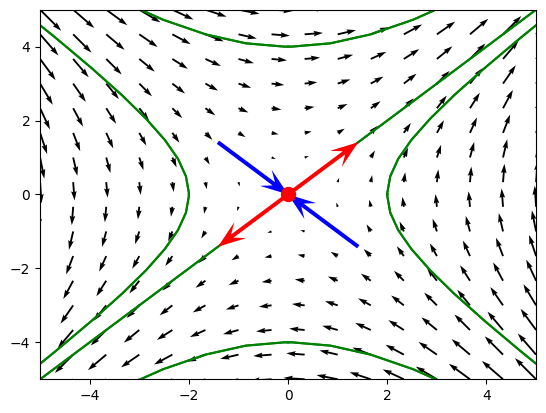

In [36]:
# 2,1 - устойчивый узел, 1,3 - устойчивый фокус, 1,1 - вырожденный устойчивый узел, -2,1 - неустойчивый узел, -1,3 - неустойчивый фокус
# 0,1 - центр, 0,-1 - седло
# задаем коэффициенты сигма гамма
sigma = 0
gamma = -1

print (f"sigma = {sigma}, gamma = {gamma}")
print(f"Уравнение: x'' + {2*sigma}x' + {gamma}x = 0")

# вычисляем собственные числа, вектора, матрицу якоби (возможно матрицу якоби не надо)
eigenvalues, eigenvectors = solve_eigenvalues_and_jacobian(sigma, gamma)
print(f"Собственные числа = {eigenvalues}")
print(f"Собственные вектора = \n{eigenvectors}")
# определяем, какое состояние равновесия перед нами, так же вспомогательное число для дальнейшего использования
type_name, type_number = stability_type(eigenvalues)[0], stability_type(eigenvalues)[1]
print(f"Тип состояния: {type_name}")
# рисуем сепаратрисы ( или один собственный вектор для узла )
plot_eigendirections_arrows(eigenvalues,eigenvectors, type_number, 2)
# рисуем точку
plot_equilibrium(type_number)


# отрисовка векторного поля
rhs = f1(sigma,gamma)
drawing_vector_field(rhs, [(-5.,5.),(-5.,5.)])

# список начальных условий
initial_conditions = [
    [0, 4],
    [0, -4],
    [2, 0],
    [-2, 0],
    [3, 3],
    [-3, -3]
]

# список временных интервалов для интегрирования
t_intervals = [[0, -50], [-50, 0], [50, 0], [0, 50]]

# отрисовка численного решения
for X0 in initial_conditions:
    for t_span in t_intervals:
        sol = solve_ivp(rhs, t_span, X0, method='RK45', rtol=1e-12)
        plt.plot(sol.y[0], sol.y[1], 'g-')  # траектории зелёным


